In [83]:
# import packages
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Data Exploration

In [84]:
submission = pd.read_csv("SampleSubmission.csv",index_col='Order_No')
train_data = pd.read_csv("Train.csv",index_col='Order No')
test_data = pd.read_csv('Test.csv', index_col='Order No')
var_definition = pd.read_csv('VariableDefinitions.csv')
riders = pd.read_csv('Riders.csv', index_col = 'Rider Id')

#### Variable Definitions
- **User Id**: Unique number identifying the customer on a platform
- **Vehicle Type**: For this competition limited to bikes, however in practice Sendy service extends to trucks and vans
- **Platform Type**: Platform used to place the order, there are 4 types
- **Personal or Business**: Customer type
- **Placement - Day of Month**: Placement - Day of Month i.e 1-31
- **Placement - Weekday (Mo = 1)**: Placement - Weekday (Monday = 1)
- **Placement - Time**: Placement - Time - Time of day the order was placed
- **Confirmation - Day of Month**: Confirmation - Day of Month i.e 1-31
- **Confirmation - Weekday (Mo = 1)**: Confirmation - Weekday (Monday = 1)
- **Confirmation - Time**: Confirmation - Time - Time of day the order was confirmed by a rider
- **Arrival at Pickup - Day of Month**: Arrival at Pickup - Day of Month i.e 1-31
- **Arrival at Pickup - Weekday (Mo = 1)**: Arrival at Pickup - Weekday (Monday = 1)
- **Arrival at Pickup - Time**: Time of day the the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application
- **Pickup - Day of Month**: Pickup - Day of Month i.e 1-31
- **Pickup - Weekday (Mo = 1)**: Pickup - Weekday (Monday = 1)
- **Pickup - Time**: Pickup - Time - Time of day the the rider picked up the order - as marked by the rider through the Sendy application
- **Arrival at Destination - Day of Month**: Arrival at Delivery - Day of Month i.e 1-31
- **Arrival at Destination - Weekday (Mo = 1)**: Arrival at Delivery - Weekday (Monday = 1)
- **Arrival at Destination - Time**: Arrival at Delivery Time - Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application
- **Distance (KM)**: The distance from Pickup to Destination
- **Temperature**: Temperature at the time of order placement in Degrees Celsius (measured every three hours)
- **Precipitation in millimeters**:  Precipitation at the time of order placement (measured every three hours)
- **Pickup Lat**: Latitude of pick up location
- **Pickup Long**: Longitude of pick up location
- **Destination Lat**: Latitude of delivery location
- **Destination Long**: Longitude of delivery location
- **Rider Id**:  ID of the Rider who accepted the order
- **Time from Pickup to Arrival**: Time in seconds between 'Pickup' and 'Arrival at Destination' - calculated from the columns for the purpose of facilitating the task
- **Rider Metrics**: nan
- **No_Of_Orders**:  Number of Orders the rider has delivered
- **Age**: Number of days since the rider delivered the first order
- **Average_Rating**: Average rating of the rider
- **No_of_Ratings**:  Number of ratings the rider has received. Rating an order is optional for the customer.

In [85]:
train_column_names = train_data.columns.values
test_column_names = test_data.columns.values
target_vars = set(train_column_names) - set(test_column_names)
print('Target columns')
list(target_vars)

Target columns


['Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival',
 'Arrival at Destination - Day of Month']

In [86]:
train_data = pd.merge(left = train_data,
                right = riders,
                how = 'left',
                left_on = 'Rider Id',
                right_index= True)

test_data = pd.merge(left = test_data,
                right = riders,
                how = 'left',
                left_on = 'Rider Id',
                right_index= True)

In [87]:
train_data.head()

,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


### Data Structures

In [88]:
# convert to categories

category_vars =  ['Vehicle Type','Platform Type','Personal or Business']

def categories(df):
    
    global category_vars
    
    for col_name in category_vars:
        df[col_name]=df[col_name].astype('category')
        
categories(train_data)
categories(test_data)

In [89]:
def checkDataType(df, column_name):
    dtype = df[column_name].dtype
    return str(dtype)

def classifyColumnsByDataType(df):
    
        numeric_type = ['int16', 'int64', 'float16', 'float64']
        factor_type = ['object']
        
        numeric_vars = []
        factor_vars = []
        
        for column_name in df.columns:
            data_type = checkDataType(df,column_name)
            
            if column_name not in list(target_vars) + category_vars:
                if data_type in numeric_type:
                    numeric_vars.append(column_name)
                else:
                    factor_vars.append(column_name)
        return numeric_vars, factor_vars
    
numeric_vars, factor_vars = classifyColumnsByDataType(train_data)

In [90]:
def convertToTime(df):
    
    time_vars = []
    for column_name in df.loc[:, factor_vars].columns.to_list():

        if column_name.find("Time") != -1:

            print('{} :'.format(column_name), 'Found')
            time_vars.append(column_name)
            factor_vars.remove(column_name)
            
            df['{}'.format(column_name)] = df.loc[:, column_name].map(lambda timestring: pd.to_datetime(timestring).time())
            
    return time_vars

time_vars = convertToTime(df = train_data)
train_data[time_vars].head()

Placement - Time : Found
Confirmation - Time : Found
Arrival at Pickup - Time : Found
Pickup - Time : Found


,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
Order No,,,,
Order_No_4211,09:35:46,09:40:10,10:04:47,10:27:30
Order_No_25375,11:16:16,11:23:21,11:40:22,11:44:09
Order_No_1899,12:39:25,12:42:44,12:49:34,12:53:03
Order_No_9336,09:25:34,09:26:05,09:37:56,09:43:06
Order_No_27883,09:55:18,09:56:18,10:03:53,10:05:23


geographical distance
- Manipulate the distance data using Haversine formula

In [91]:
geo_vars = []
for col in train_data.columns:
    if 'Lat' in col or 'Long' in col:
        geo_vars.append(col)
geo_data = train_data[geo_vars+['Distance (KM)','Time from Pickup to Arrival']]
geo_data.head()

,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Distance (KM),Time from Pickup to Arrival
Order No,,,,,,
Order_No_4211,-1.317755,36.830370,-1.300406,36.829741,4,745
Order_No_25375,-1.351453,36.899315,-1.295004,36.814358,16,1993
Order_No_1899,-1.308284,36.843419,-1.300921,36.828195,3,455
Order_No_9336,-1.281301,36.832396,-1.257147,36.795063,9,1341
Order_No_27883,-1.266597,36.792118,-1.295041,36.809817,9,1214


In [92]:
new_distance = []
for val in range(len(train_data)):
    p = math.pi/180
    cos = math.cos
    lat1 = geo_data.iloc[val][0]
    long1 = geo_data.iloc[val][1]
    lat2 = geo_data.iloc[val][2]
    long2 = geo_data.iloc[val][3]
    
    lat_diff = lat2-lat1
    long_diff = long2-long1

    cal_1 = cos(lat_diff*p)/2
    cal_2 = cos(lat1*p) * cos(lat2*p)
    cal_3 = (1-cos((long_diff/2)*p))/2

    fin = 0.5 - cal_1 + cal_2*cal_3

    new_distance.append(12742 * math.asin(math.sqrt(fin)))

geo_data['new_distance'] = new_distance
train_data['Distance (KM)']=geo_data['new_distance']
train_data['Distance (KM)'] = train_data['Distance (KM)'].astype('float')
del geo_data
train_data.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,09:35:46,9,5,09:40:10,9,5,10:04:47,9,5,10:27:30,9,5,10:39:55 AM,1.929382,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16,12,5,11:23:21,12,5,11:40:22,12,5,11:44:09,12,5,12:17:22 PM,7.854744,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25,30,2,12:42:44,30,2,12:49:34,30,2,12:53:03,30,2,1:00:38 PM,1.177471,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,09:25:34,15,5,09:26:05,15,5,09:37:56,15,5,09:43:06,15,5,10:05:27 AM,3.394053,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,09:55:18,13,1,09:56:18,13,1,10:03:53,13,1,10:05:23,13,1,10:25:37 AM,3.312232,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


### Missing Values

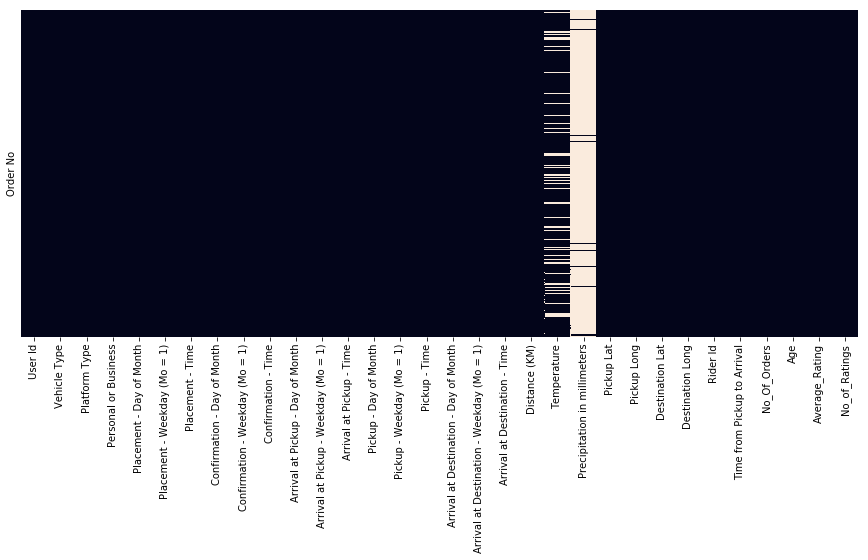

In [93]:
plt.figure(figsize=(15,6))
sns.heatmap(data=train_data.isnull(),yticklabels=False,cbar=False)

replace the missing values for the Temperature column
remove the precipitation column as it contains insufficient data

In [94]:
def missing_values(df):
    # impute the mean
    col = 'Temperature'
    df[col].fillna(df[col].mean(),inplace=True)
    
    # drop the 'Precipitation column'
    df = df.drop('Precipitation in millimeters',1)
    
    return df

train_data = missing_values(train_data)
test_data = missing_values(test_data)

### Data exploration

In [95]:
train_data.shape

(21201, 31)

- create dummy variables for the platform and business/personal classification

In [96]:
# create dummy variables for the categorical columns
def dummy(df):
    business_dummies = pd.get_dummies(data=df['Personal or Business'],drop_first = True)

    # concatinate the dummy dataframes with df
    df = pd.concat([df,business_dummies],axis=1)

    df.drop(columns=['Personal or Business'],axis=1,inplace=True)
    
    return df

train_data = dummy(train_data)
test_data = dummy(test_data)

- make the dependent variable the last column

In [97]:
def arrange_df(df):
    df.insert(loc=1,column='Rider_Id',value = df['Rider Id'])
    df.drop('Rider Id',axis=1,inplace=True)

    df.columns = [col_name.replace(' ','_') for col_name in list(df.columns)]
    df.rename({'Distance_(KM)':'Distance_KM'},axis=1,inplace=True)

    last_col = 'Time_from_Pickup_to_Arrival'

    plat = [col for col in list(df.columns) if col != 'Platform_Type']+['Platform_Type']
    df = df[plat]
    
    if last_col in df.columns:
        arranged_col = [col for col in list(df.columns) if col != last_col]+[last_col]
        df = df[arranged_col]
    
    return df

train_data = arrange_df(train_data)
test_data = arrange_df(test_data)

In [98]:
train_data.head().T

Order No,Order_No_4211,Order_No_25375,Order_No_1899,Order_No_9336,Order_No_27883
User_Id,User_Id_633,User_Id_2285,User_Id_265,User_Id_1402,User_Id_1737
Rider_Id,Rider_Id_432,Rider_Id_856,Rider_Id_155,Rider_Id_855,Rider_Id_770
Vehicle_Type,Bike,Bike,Bike,Bike,Bike
Placement_-_Day_of_Month,9,12,30,15,13
Placement_-_Weekday_(Mo_=_1),5,5,2,5,1
Placement_-_Time,09:35:46,11:16:16,12:39:25,09:25:34,09:55:18
Confirmation_-_Day_of_Month,9,12,30,15,13
Confirmation_-_Weekday_(Mo_=_1),5,5,2,5,1
Confirmation_-_Time,09:40:10,11:23:21,12:42:44,09:26:05,09:56:18
Arrival_at_Pickup_-_Day_of_Month,9,12,30,15,13


- Select numerical columns to include in the model

In [99]:
train_data_split = train_data[list(train_data.columns[18:])]

In [100]:
train_data_split.shape

(21201, 13)

In [101]:
train_data_split.head()

,Distance_KM,Temperature,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal,Platform_Type,Time_from_Pickup_to_Arrival
Order No,,,,,,,,,,,,,
Order_No_4211,1.929382,20.400000,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,0,3,745
Order_No_25375,7.854744,26.400000,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,1,3,1993
Order_No_1899,1.177471,23.258889,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114,0,3,455
Order_No_9336,3.394053,19.200000,-1.281301,36.832396,-1.257147,36.795063,886,283,14.5,113,0,3,1341
Order_No_27883,3.312232,15.400000,-1.266597,36.792118,-1.295041,36.809817,2311,872,14.1,533,1,1,1214


#### Lookout for any multicollinearity issues

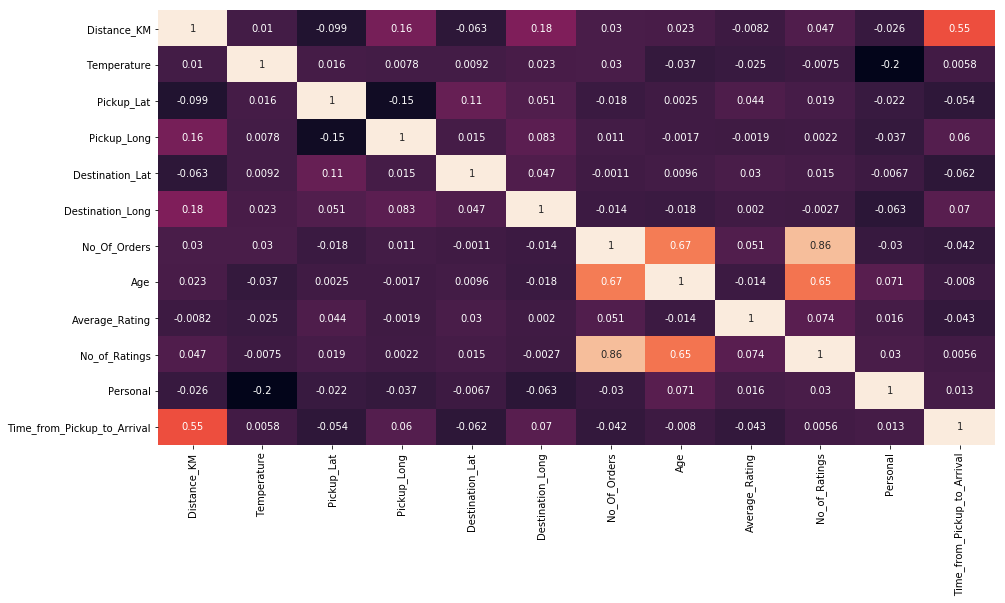

In [102]:
plt.figure(figsize=(15,8))
sns.heatmap(data=train_data_split.corr(),cbar=False,annot=True)

- Explore the Time_from_Pickup_to_Arrival variable

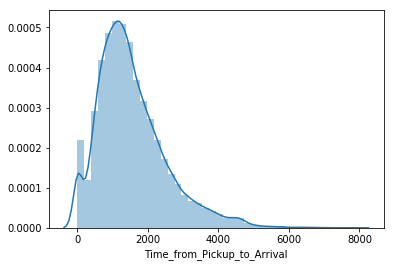

In [103]:
sns.distplot(train_data['Time_from_Pickup_to_Arrival'],bins=40)

In [104]:
print(f"mean = {train_data['Time_from_Pickup_to_Arrival'].mean()}")
print(f"min = {train_data['Time_from_Pickup_to_Arrival'].min()}")
print(f"max = {train_data['Time_from_Pickup_to_Arrival'].max()}")

mean = 1556.9209471251356
min = 1
max = 7883


In [105]:
dist_avg = train_data[train_data['Time_from_Pickup_to_Arrival']<60*5]['Distance_KM'].mean()

In [106]:
delivery_time_average = train_data[train_data['Distance_KM']<=dist_avg][['Time_from_Pickup_to_Arrival']].mean()

In [107]:
arrival = []

for value in train_data['Time_from_Pickup_to_Arrival']:
    if value==1:
        arrival.append(delivery_time_average)
    else:
        arrival.append(value)
        
train_data['Time_from_Pickup_to_Arrival'] = arrival
train_data['Time_from_Pickup_to_Arrival'] = train_data['Time_from_Pickup_to_Arrival'].astype('int')

In [108]:
train_data['Time_from_Pickup_to_Arrival'].dtype

dtype('int32')

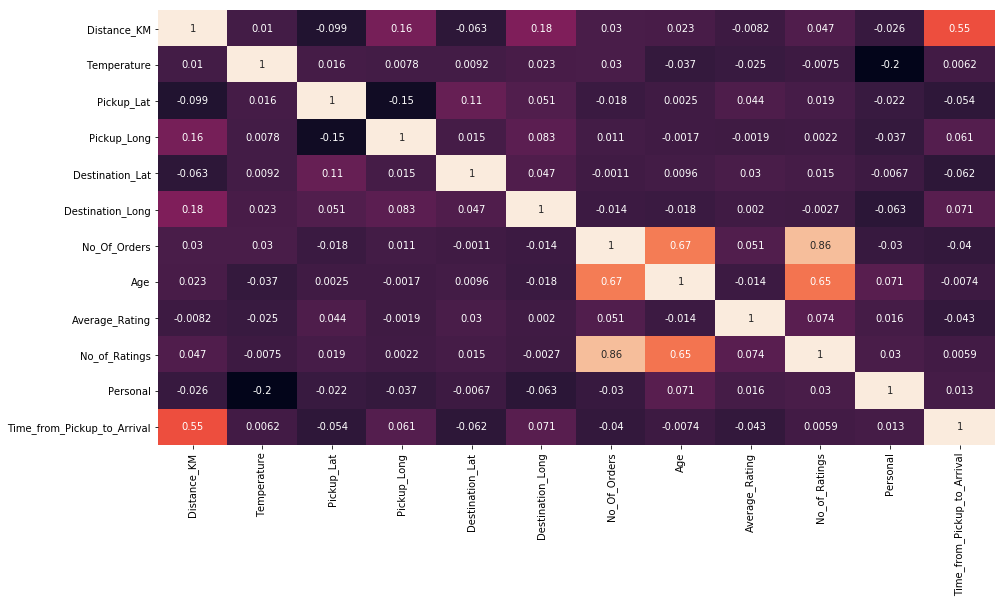

In [109]:
train_data_split = train_data[list(train_data.columns[18:])]
plt.figure(figsize=(15,8))
sns.heatmap(data=train_data_split.corr(),cbar=False,annot=True)

#### train_test split

In [110]:
# dependent and independent variabes defined
X = train_data_split.iloc[:, :-1].values
y = train_data_split.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Model_1

In [111]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

from sklearn.metrics import r2_score,mean_squared_error
print(f'R_square:\t{r2_score(y_test,y_pred)*100}')
print(f'RMSE:\t\t{np.sqrt(mean_squared_error(y_test,y_pred))}')

R_square:	31.771692653146477
RMSE:		810.8558494416968


### model_2

In [112]:
from sklearn.preprocessing import StandardScaler

train_scaler = StandardScaler()
test_scaler = StandardScaler()

In [113]:
# standardise the independent variables
X_train_t = train_scaler.fit_transform(X_train)
X_test_t = test_scaler.fit_transform(X_test)

# standardise the dependent variable
y_train_t = train_scaler.fit_transform(y_train)
y_test_t = test_scaler.fit_transform(y_test)

In [114]:

lm = LinearRegression()
lm.fit(X_train_t,y_train_t)

y_pred = lm.predict(X_test_t)
print(f'R_square:\t{r2_score(y_test_t,y_pred)*100}')
print(f'RMSE:\t\t{np.sqrt(mean_squared_error(test_scaler.inverse_transform(y_test_t),test_scaler.inverse_transform(y_pred)))}')

R_square:	31.7745530581082
RMSE:		810.8388520948837


- **insignificant impact from the standardisation process**

In [115]:
from statsmodels.formula.api import ols

# Model DataFrame with all of the columns:
dfm = train_data_split.copy()

# The dependent variable:
y_name = 'Time_from_Pickup_to_Arrival'
# The independent variable
# (let's first try all of the columns in the model DataFrame)
X_names = [col for col in dfm.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 Time_from_Pickup_to_Arrival ~ Distance_KM + Temperature + Pickup_Lat + Pickup_Long + Destination_Lat + Destination_Long + No_Of_Orders + Age + Average_Rating + No_of_Ratings + Personal + Platform_Type


In [116]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.317
Model:                                     OLS   Adj. R-squared:                  0.316
Method:                          Least Squares   F-statistic:                     701.9
Date:                         Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                                 09:38:21   Log-Likelihood:            -1.7218e+05
No. Observations:                        21201   AIC:                         3.444e+05
Df Residuals:                            21186   BIC:                         3.445e+05
Df Model:                                   14                                         
Covariance Type:                     nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

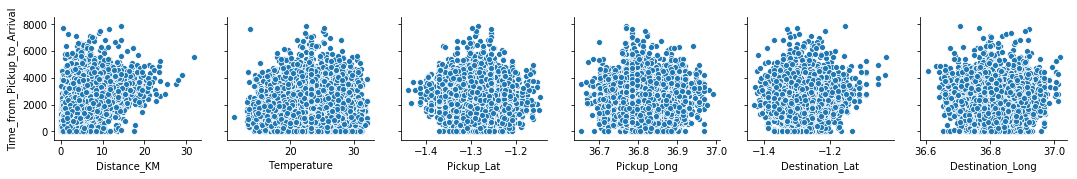

In [117]:
sns.pairplot(train_data_split,x_vars=train_data_split.columns[:6],y_vars=y_name,)

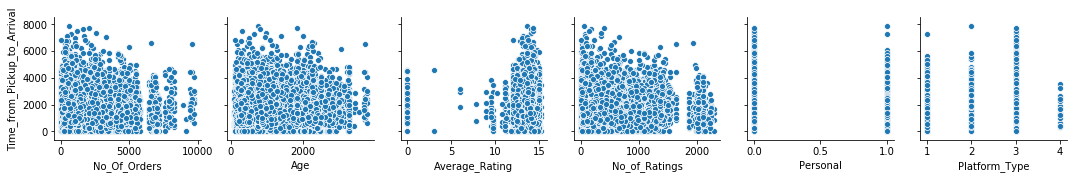

In [118]:
sns.pairplot(train_data_split,x_vars=train_data_split.columns[6:-1],y_vars=y_name)

In [119]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Placement_-_Day_of_Month,21201.0,15.653696,8.798916,1.000000,8.000000,15.000000,23.000000,31.000000
Placement_-_Weekday_(Mo_=_1),21201.0,3.240083,1.567295,1.000000,2.000000,3.000000,5.000000,7.000000
Confirmation_-_Day_of_Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Confirmation_-_Weekday_(Mo_=_1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival_at_Pickup_-_Day_of_Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival_at_Pickup_-_Weekday_(Mo_=_1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup_-_Day_of_Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup_-_Weekday_(Mo_=_1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival_at_Destination_-_Day_of_Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival_at_Destination_-_Weekday_(Mo_=_1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000


### model_3

In [120]:
# dependent and independent variabes defined
X = train_data_split.iloc[:, :-1].values
y = train_data_split.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#### test_model

In [121]:
train_data_split.columns[:-1]

Index(['Distance_KM', 'Temperature', 'Pickup_Lat', 'Pickup_Long',
       'Destination_Lat', 'Destination_Long', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings', 'Personal', 'Platform_Type'],
      dtype='object')

In [122]:
X_test_values = test_data[train_data_split.columns[:-1]].values

In [123]:
predictions = pd.DataFrame(data=lm.predict(X_test_values),index=test_data.index,columns=['Time from Pickup to Arrival'])

In [124]:
pd.DataFrame(data=lm.coef_,columns=train_data_split.columns[:-1]).T

,0
Distance_KM,0.559861
Temperature,0.014311
Pickup_Lat,0.000662
Pickup_Long,-0.024665
Destination_Lat,-0.025016
Destination_Long,-0.025270
No_Of_Orders,-0.147988
Age,0.010725
Average_Rating,-0.032718
No_of_Ratings,0.100797


In [125]:
# predictions.to_csv('submission.csv')

### try XGB regressor boosting
- no standardisation

In [126]:
from xgboost import XGBRegressor

In [127]:
xgb = XGBRegressor()

In [128]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [129]:
y_pred =xgb.predict(X_test)

In [130]:
print(f'R_square:\t{r2_score(y_test,y_pred)*100}')
print(f'RMSE:\t\t{np.sqrt(mean_squared_error(y_test,y_pred))}')

R_square:	38.2204136426655
RMSE:		771.5851374775156


In [81]:
predictions = pd.DataFrame(data=xgb.predict(X_test_values),index=test_data.index,columns=['Time from Pickup to Arrival'])
# new = pd.merge(left = predictions,right=pd.read_csv('submission.csv',index_col=0),
#         left_index=True,right_index=True)
# new['diff'] = new['Time from Pickup to Arrival_x']-new['Time from Pickup to Arrival_y']
# new

In [82]:
# predictions.to_csv('submission.csv')